In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import holidays
#import datetime
#from datetime import date

from scipy.stats import binned_statistic_2d

import os
import glob 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.linear_model import LinearRegression, ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import warnings
warnings.filterwarnings('ignore')


In [2]:
regions_102 = pd.read_csv('regions_102.csv', index_col='region') # берем отобранные нами на 2ой неделе 102 региона

#### 1. Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте $Q_{may}$— качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.


Чтобы не загромождать ноутбук, приведу только итоговые результаты из 5-ой недели: **Q_may = 20.501195664976912**.     Расчеты можно посмотреть здесь: https://www.coursera.org/learn/data-analysis-project/peer/YhEKS/proghnozirovaniie-s-pomoshch-iu-rieghriessii/review/6nSnbv8OEeqyBwrZjYZLLQ

Для модели использовались следующие признаки:

* 89 фурье-компонент, как недельных, так и годовых;
* год, месяц, день месяца, день недели, час;
* количество поездок из рассматриваемого региона в моменты времени, предшествующему прогнозируемому **sum_k** и суммарного кол-ва за **sum_n**; (sum_k = [1, 2, 3, 4, 5, 6, 24, 48]; sum_n = [12, 24, 168])
* полиномиальные признаки из пункта выше (попарные произведения);

Использовалась **ElasticNet** регрессия (Linear regression with combined L1 and L2 priors as regularizer)

#### 2. Добавление признаков. Обучение обновлённой модели на данных до апреля 2016 включительно и подсчет качества новых прогнозов на мае.

In [3]:
years_aggr_delta_tpep_datetime = pd.DataFrame()
years_aggr_trip_distance = pd.DataFrame()
years_aggr_passenger = pd.DataFrame()
years_aggr_total_amount = pd.DataFrame()

In [ ]:
k = 0

for filename in glob.glob('D:\TAXI_all_files\*.csv'):
    month_year = pd.read_csv(filename, parse_dates=[1, 2], low_memory=False)
    
    month_year.columns = month_year.columns.str.replace(' ', '') # удаляем пробелы в заголовках
    
    # ввиду того, что названия колонок меняются,вводим переменную recharge_cols 
    recharge_cols = [col for col in month_year.columns if 'pickup_datetime' in col or 'dropoff_datetime' in col]
    recharge_cols.extend(['passenger_count', 'trip_distance','pickup_longitude', 'pickup_latitude', 'total_amount'])
    
    k += 1
    print (filename)
    month_year = month_year[recharge_cols]
    
    # Очистка от аномальных и не попадающих под условия задачи значений:

    indexNames = month_year[(month_year['trip_distance'] == 0) | (month_year['passenger_count'] == 0)
                          | (month_year['pickup_longitude'] < -74.25559) | (month_year['pickup_longitude'] > -73.70001) 
                          | (month_year['pickup_latitude'] < 40.49612) | (month_year['pickup_latitude'] > 40.91553)].index
    month_year.drop(indexNames , inplace=True)
    
    # Выявление аномальных поездок с нулевой длительнотью по времени (и отрицательной)

    month_year['delta_tpep_datetime'] = month_year.iloc[:, 1] - month_year.iloc[:, 0]

    indexNames = month_year[(month_year['delta_tpep_datetime'] <= '00:00:00')].index
    month_year.drop(indexNames , inplace=True)
    
    # длительность поездки будем считать в минутах:
    month_year['delta_tpep_datetime'] = month_year['delta_tpep_datetime']/np.timedelta64(1, 'm')
    
    # Отбрасываем минуты и секунды во времени начала поездки
    month_year.iloc[:, 0] = month_year[recharge_cols[0]].dt.floor("H")
    
    # выкидываем колонку dropoff_datetime, т.к. она нам больше не нужна: 
    month_year.drop([recharge_cols[1]], axis=1, inplace=True)
    
    # Формирование 2500 областей:
    range_1 = [[-74.25559, -73.70001], [40.49612, 40.91553]]
    ret = binned_statistic_2d(month_year.pickup_longitude, month_year.pickup_latitude, month_year.pickup_longitude, 'count',
                              bins=[50, 50], expand_binnumbers=True, range=range_1)
    
    # Перевод в одномерную сетку
    month_year['region'] = (ret[3][0] - 1) * 50 + ret[3][1]
    
    # группируем по длительности поездки
    month_year_aggr_delta_tpep_datetime = month_year[[recharge_cols[0], 'delta_tpep_datetime', 'region']]
    month_year_aggr_delta_tpep_datetime = month_year_aggr_delta_tpep_datetime.pivot_table(
                                                    index=['region'], 
                                                    columns=recharge_cols[0], values='delta_tpep_datetime', 
                                                    aggfunc='mean', dropna=True, fill_value=0)
    month_year_aggr_delta_tpep_datetime = month_year_aggr_delta_tpep_datetime.loc[regions_102.index].T
    
    # группируем по расстоянию поездки:
    month_year_aggr_trip_distance = month_year[[recharge_cols[0], 'trip_distance', 'region']]
    month_year_aggr_trip_distance = month_year_aggr_trip_distance.pivot_table(
                                              index=['region'], 
                                              columns=recharge_cols[0], values='trip_distance', 
                                              aggfunc='mean', dropna=True, fill_value=0)
    month_year_aggr_trip_distance = month_year_aggr_trip_distance.loc[regions_102.index].T
    
    # группируем по среднему количеству пассажиров:
    month_year_aggr_passenger = month_year[[recharge_cols[0], 'passenger_count', 'region']]
    month_year_aggr_passenger = month_year_aggr_passenger.pivot_table(
                                              index=['region'], 
                                              columns=recharge_cols[0], values='passenger_count', 
                                              aggfunc='mean', dropna=True, fill_value=0)
    month_year_aggr_passenger = month_year_aggr_passenger.loc[regions_102.index].T
    
    # группируем по средней стоимости поездок:
    month_year_aggr_total_amount = month_year[[recharge_cols[0], 'total_amount', 'region']]
    month_year_aggr_total_amount = month_year_aggr_total_amount.pivot_table(
                                              index=['region'], 
                                              columns=recharge_cols[0], values='total_amount', 
                                              aggfunc='mean', dropna=True, fill_value=0)
    month_year_aggr_total_amount = month_year_aggr_total_amount.loc[regions_102.index].T
       
    
    years_aggr_delta_tpep_datetime = pd.concat([years_aggr_delta_tpep_datetime, month_year_aggr_delta_tpep_datetime], axis=0)
    years_aggr_trip_distance = pd.concat([years_aggr_trip_distance, month_year_aggr_trip_distance], axis=0)
    years_aggr_passenger = pd.concat([years_aggr_passenger, month_year_aggr_passenger], axis=0)
    years_aggr_total_amount = pd.concat([years_aggr_total_amount, month_year_aggr_total_amount], axis=0)

In [ ]:
# Закомментирую,чтоб случайно не затереть полученные данные!!!(сохранение произведено!)

#years_aggr_delta_tpep_datetime.to_csv('years_aggr_delta_tpep_datetime.csv')
#years_aggr_trip_distance.to_csv('years_aggr_trip_distance.csv')
#years_aggr_passenger.to_csv('years_aggr_passenger.csv')
#years_aggr_total_amount.to_csv('years_aggr_total_amount.csv')

In [4]:
years_aggr_delta_tpep_datetime = pd.read_csv('years_aggr_delta_tpep_datetime.csv', parse_dates=[0], index_col=0)
years_aggr_trip_distance = pd.read_csv('years_aggr_trip_distance.csv', parse_dates=[0], index_col=0)
years_aggr_passenger = pd.read_csv('years_aggr_passenger.csv', parse_dates=[0], index_col=0)
years_aggr_total_amount = pd.read_csv('years_aggr_total_amount.csv', parse_dates=[0], index_col=0)

In [5]:
display(years_aggr_delta_tpep_datetime)
display(years_aggr_trip_distance)
display(years_aggr_passenger)
display(years_aggr_total_amount)  

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2013-01-01 00:00:00,13.580222,13.011745,12.511174,13.413860,12.878788,12.445849,12.938412,12.936324,13.571971,13.379775,...,11.650000,0.000000,13.835185,17.764602,15.596914,24.363158,25.444444,25.314461,23.075926,22.179104
2013-01-01 01:00:00,16.419753,14.319036,16.393621,14.409259,13.650332,14.136043,13.509846,13.773435,13.752977,14.245152,...,14.668939,0.000000,11.277778,8.297619,10.390000,25.004545,27.438889,23.461789,41.416667,31.534444
2013-01-01 02:00:00,16.323780,14.590021,14.932329,14.805679,13.313435,13.772187,13.317979,12.185724,12.345868,12.743056,...,9.386957,0.000000,9.900000,15.450000,10.638889,11.500000,0.000000,16.461310,0.000000,20.118750
2013-01-01 03:00:00,16.706540,14.934016,11.968056,13.822170,12.916321,12.818292,12.950484,12.106924,12.621711,12.282026,...,11.599333,0.000000,3.383333,8.000000,7.402381,15.500000,0.000000,10.494444,0.000000,5.766667
2013-01-01 04:00:00,15.790000,14.702247,16.318333,12.642373,12.152210,13.348544,13.279001,11.907386,11.800282,11.855072,...,9.169231,0.000000,14.141667,13.730000,15.825000,21.844444,0.000000,22.978889,14.500000,25.436458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,20.059914,35.527281,15.052963,21.899369,24.049831,16.903680,16.816500,12.199950,12.370262,18.176987,...,6.366667,26.645076,19.845833,28.449270,29.118703,47.344551,55.683333,45.469836,43.981597,65.216667
2016-06-30 20:00:00,20.254327,16.081573,14.752685,28.535106,17.284535,15.283650,17.453462,12.445714,12.159702,12.686302,...,7.566667,22.533951,17.019048,26.648206,27.320010,48.352751,50.375000,48.180941,45.697931,0.000000
2016-06-30 21:00:00,29.242163,18.192901,16.827241,17.502222,17.668199,20.750316,17.920797,14.216667,14.000397,13.724968,...,6.633333,30.980952,18.800000,37.776771,42.110586,49.595946,51.751852,51.039593,46.407981,0.333333
2016-06-30 22:00:00,22.657233,22.440179,21.758414,20.459867,20.615668,19.405357,22.409753,14.155512,19.286246,13.533269,...,16.961111,42.370175,27.776667,44.055121,44.156761,51.194970,43.931944,51.394579,51.240068,0.000000


,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2013-01-01 00:00:00,4.581733,4.063758,3.480455,4.298737,3.662795,3.054535,2.975017,2.767932,2.772794,2.660899,...,3.507500,0.000000,7.966667,8.888496,8.372963,13.220000,14.033333,14.596471,14.191667,13.004627
2013-01-01 01:00:00,4.889167,4.140392,4.392469,5.019444,4.094055,3.197850,2.968494,2.760851,2.727237,2.694591,...,3.650000,0.000000,6.380000,2.387143,3.120000,13.146364,16.613333,12.825000,25.300000,18.166667
2013-01-01 02:00:00,5.537683,4.633395,4.344458,4.708815,4.020886,3.462718,3.249106,2.738343,2.928347,3.151859,...,2.516957,0.000000,2.200000,4.016667,3.033333,7.055000,0.000000,8.847143,0.000000,11.161250
2013-01-01 03:00:00,6.302152,4.901230,4.057083,4.343396,4.003702,3.546079,3.527254,3.252505,3.285223,2.945490,...,3.888000,0.000000,0.800000,0.950000,2.357143,11.925000,0.000000,5.638333,0.000000,3.800000
2013-01-01 04:00:00,6.225143,5.105281,6.138000,4.718305,4.156740,4.137169,3.656446,3.404169,3.174633,3.626196,...,2.560769,0.000000,4.900000,5.762000,7.200000,15.713333,0.000000,12.954000,9.085000,15.949375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,4.020431,3.772316,3.054667,4.172500,3.741544,2.669481,2.130150,1.887381,2.100423,2.261538,...,0.700000,8.812500,6.655000,9.088855,9.750064,16.289808,17.833333,16.059366,15.030938,19.460000
2016-06-30 20:00:00,4.463173,3.662254,3.442416,4.331915,3.796877,2.764837,2.477513,2.079377,2.080643,2.518623,...,1.390000,8.265556,7.081429,9.219931,9.731599,16.154466,17.722500,16.219569,16.619586,0.000000
2016-06-30 21:00:00,4.939801,4.334506,4.384345,4.042074,4.087298,3.404787,2.829130,2.603623,2.729598,3.005598,...,2.000000,9.018571,7.285556,9.460906,10.151792,16.097784,15.784444,16.831831,15.477817,2.300000
2016-06-30 22:00:00,5.347358,4.587381,3.918641,4.627760,4.418959,3.349643,3.101580,2.709508,2.845381,2.950541,...,4.073333,8.160000,5.430000,9.498966,9.974057,16.434024,14.464167,16.824854,16.157740,0.000000


,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2013-01-01 00:00:00,1.800000,1.973154,1.954545,1.810526,1.959596,1.953532,1.870370,1.881664,1.887605,1.947566,...,2.083333,0.000000,3.444444,1.805310,2.370370,1.842105,1.500000,1.661765,1.833333,1.641791
2013-01-01 01:00:00,1.916667,1.955882,1.913580,1.952381,1.875622,1.919580,1.843629,1.892456,2.045802,2.004545,...,2.045455,0.000000,2.000000,1.857143,1.400000,1.909091,2.333333,1.841463,1.000000,1.200000
2013-01-01 02:00:00,1.768293,1.876543,1.831325,1.800000,1.855956,1.927813,2.017021,1.860606,1.840909,1.807692,...,1.652174,0.000000,2.000000,1.333333,1.000000,2.000000,0.000000,1.535714,0.000000,1.687500
2013-01-01 03:00:00,1.835443,2.278689,2.041667,2.169811,2.038062,1.952282,1.979911,1.912206,1.905045,2.019608,...,1.320000,0.000000,1.000000,2.000000,1.428571,2.000000,0.000000,1.666667,0.000000,1.000000
2013-01-01 04:00:00,1.800000,1.730337,1.700000,2.101695,1.944751,2.036145,1.838196,1.932945,1.951977,1.880435,...,2.038462,0.000000,2.500000,1.600000,2.000000,1.000000,0.000000,1.600000,1.000000,2.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,1.439655,1.642105,1.755556,1.530303,1.650633,1.652597,1.670823,1.482143,1.741935,1.496154,...,1.500000,1.590909,1.250000,1.740741,1.758842,1.846154,1.555556,1.690141,1.718750,6.000000
2016-06-30 20:00:00,1.567308,1.661972,1.671141,1.503546,1.522523,1.687500,1.707692,1.651948,1.617857,1.534413,...,1.000000,1.703704,1.142857,1.690972,1.572674,1.621359,1.375000,1.679426,1.841379,0.000000
2016-06-30 21:00:00,1.529801,1.524691,1.641379,1.577778,1.665738,1.715640,1.606522,1.632163,1.729167,1.710425,...,1.000000,1.857143,1.666667,1.682927,1.550489,1.637838,1.111111,1.690141,1.654930,1.000000
2016-06-30 22:00:00,1.594340,1.541667,1.601942,1.640000,1.589905,1.617647,1.634568,1.620079,1.631488,1.822394,...,1.333333,1.684211,1.200000,1.770950,1.689922,1.715976,1.166667,1.679612,1.753425,0.000000


,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2013-01-01 00:00:00,18.605867,16.715235,15.708182,17.761684,16.042997,14.542193,14.787441,14.147334,14.384317,14.242846,...,14.400000,0.000000,30.277778,32.962035,30.764444,52.422632,50.221667,50.148529,45.440000,41.314478
2013-01-01 01:00:00,20.261019,18.118824,20.435309,18.983730,17.300746,15.610787,14.902046,14.737994,14.507557,14.971182,...,16.100455,0.000000,23.433333,11.542857,17.662000,41.187273,51.066667,40.878171,94.120000,59.794000
2013-01-01 02:00:00,21.916463,19.673148,19.407229,18.943630,17.481745,16.328195,15.877128,13.946990,13.895950,14.626859,...,11.995652,0.000000,10.500000,16.416667,15.283333,21.500000,0.000000,27.975000,0.000000,36.187500
2013-01-01 03:00:00,23.705949,20.558115,21.447917,17.720377,16.755952,16.012656,15.769509,14.964347,15.950593,14.833725,...,15.868000,0.000000,6.000000,8.000000,19.321429,34.000000,0.000000,18.650000,0.000000,13.000000
2013-01-01 04:00:00,22.240857,20.367528,25.073500,18.642712,16.622320,16.609970,15.838302,15.274490,14.653305,16.805326,...,11.442308,0.000000,17.750000,27.812000,37.750000,47.766667,0.000000,40.908333,29.000000,49.467500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,21.366466,19.969211,17.156296,22.463258,20.497797,17.095714,14.320873,13.655506,14.046673,14.420654,...,8.050000,40.671818,27.337500,39.609764,42.149164,59.342308,68.784444,59.286831,53.665521,68.760000
2016-06-30 20:00:00,22.627692,18.373873,17.905436,21.178511,18.464595,16.054783,14.860128,13.322338,13.254339,14.168583,...,8.300000,36.445185,36.630000,38.449444,40.941192,55.191068,57.005417,56.194833,55.743793,0.000000
2016-06-30 21:00:00,23.607483,20.899506,21.089103,20.082148,20.019471,18.245972,16.314065,15.124787,15.216845,16.071699,...,11.075000,39.697143,51.995556,43.595575,44.683876,52.609459,52.080000,58.786854,52.169437,69.950000
2016-06-30 22:00:00,25.551981,23.726488,22.365340,22.682400,21.790158,19.354307,17.039580,15.424390,15.950242,15.678919,...,17.966667,45.436316,29.414000,46.389581,47.537649,55.781065,47.385000,56.952961,54.310753,0.000000


In [6]:
# Формирование дополнительных признаков на основе государственных праздников и выходных:
us_holidays = holidays.CountryHoliday('US', prov=None, state='NY')

In [7]:
holiweek = pd.DataFrame(index=years_aggr_total_amount.index) # формируем DataFrame с нашими датами
holiweek['holiday'] = [1 if str(val).split()[0] in us_holidays else 0 for val in years_aggr_total_amount.index]
holiweek['weekday_1'] = ((years_aggr_total_amount.index.dayofweek) // 5 == 1).astype(int)

In [8]:
holiweek

,holiday,weekday_1
2013-01-01 00:00:00,1,0
2013-01-01 01:00:00,1,0
2013-01-01 02:00:00,1,0
2013-01-01 03:00:00,1,0
2013-01-01 04:00:00,1,0
...,...,...
2016-06-30 19:00:00,0,0
2016-06-30 20:00:00,0,0
2016-06-30 21:00:00,0,0
2016-06-30 22:00:00,0,0


$\color{blue}{\text{Теперь сформируем признаки из 5ой недели:}}$

In [9]:
# загрузка аггрегированных значений с 2013 по 2016 гг (по июнь включительно) по 102 регионам
result_102 = pd.read_csv('result_102.csv', index_col='region')
result_102_T = result_102.T

In [10]:
# Создадим общие категориальные признаки для всех регионов:
common_cat_features_5 = pd.DataFrame()
common_cat_features_5['date'] = pd.to_datetime(result_102_T.index) # привели к временному формату, чтобы извлекать признаки

# год, месяц, день месяца, день недели, час — создаем эти признаки:
common_cat_features_5['year'] = common_cat_features_5['date'].dt.year
common_cat_features_5['month'] = common_cat_features_5['date'].dt.month
common_cat_features_5['weekday'] = common_cat_features_5['date'].dt.weekday
common_cat_features_5['day'] = common_cat_features_5['date'].dt.day
common_cat_features_5['hour'] = common_cat_features_5['date'].dt.hour

In [11]:
# создание регрессионного признака для годовой и  еженедельной  сезонности
# по всему временному диапазону (с 2013-01-01 по 2016-06-30) и по нашим уже рассчитанным данным по кол-ву sin и cos на 4ой неделе:
# Для годовой сезонности значение параметра К1 = 53
# Для недельной сезонности значение параметра К2 = 36

K1 = 53
K2 = 36

s_c = pd.DataFrame()

length = result_102.shape[1]
s_c['s_0'] = np.arange(1, length+1)
for i in range(1, K1+1):
    s_c['s_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/8766)
    s_c['c_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/8766)

for i in range(1, K2+1):
    s_c['ss_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/168)
    s_c['cc_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/168)       
X_s_c = s_c.copy() 


$\color{blue}{\text{Обьединим общие категориальные и регрессионные признаки (5ую и 6ую недели):}}$

In [12]:
common_cat_features = pd.concat([common_cat_features_5, holiweek.reset_index(drop=True)], axis=1)
common_features = pd.concat([common_cat_features, X_s_c], axis=1)

In [13]:
common_features

,date,year,month,weekday,day,hour,holiday,weekday_1,s_0,s_1,...,ss_32,cc_32,ss_33,cc_33,ss_34,cc_34,ss_35,cc_35,ss_36,cc_36
0,2013-01-01 00:00:00,2013,1,1,1,0,1,0,1,0.000717,...,0.930874,0.365341,0.943883,3.302791e-01,0.955573,0.294755,0.965926,2.588190e-01,9.749279e-01,0.222521
1,2013-01-01 01:00:00,2013,1,1,1,1,1,0,2,0.001434,...,0.680173,-0.733052,0.623490,-7.818315e-01,0.563320,-0.826239,0.500000,-8.660254e-01,4.338837e-01,-0.900969
2,2013-01-01 02:00:00,2013,1,1,1,2,1,0,3,0.002150,...,-0.433884,-0.900969,-0.532032,-8.467242e-01,-0.623490,-0.781831,-0.707107,-7.071068e-01,-7.818315e-01,-0.623490
3,2013-01-01 03:00:00,2013,1,1,1,3,1,0,4,0.002867,...,-0.997204,0.074730,-0.974928,2.225209e-01,-0.930874,0.365341,-0.866025,5.000000e-01,-7.818315e-01,0.623490
4,2013-01-01 04:00:00,2013,1,1,1,4,1,0,5,0.003584,...,-0.294755,0.955573,-0.111964,9.937122e-01,0.074730,0.997204,0.258819,9.659258e-01,4.338837e-01,0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30641,2016-06-30 19:00:00,2016,6,3,30,19,0,0,30642,0.027950,...,-0.433884,-0.900969,-0.222521,9.749279e-01,0.781831,-0.623490,-1.000000,-4.782138e-13,7.818315e-01,0.623490
30642,2016-06-30 20:00:00,2016,6,3,30,20,0,0,30643,0.027234,...,-0.997204,0.074730,0.846724,5.320321e-01,-0.365341,-0.930874,-0.258819,9.659258e-01,7.818315e-01,-0.623490
30643,2016-06-30 21:00:00,2016,6,3,30,21,0,0,30644,0.026517,...,-0.294755,0.955573,0.781831,-6.234898e-01,-0.997204,0.074730,0.866025,5.000000e-01,-4.338837e-01,-0.900969
30644,2016-06-30 22:00:00,2016,6,3,30,22,0,0,30645,0.025801,...,0.781831,0.623490,-0.330279,-9.438833e-01,-0.222521,0.974928,0.707107,-7.071068e-01,-9.749279e-01,0.222521


In [14]:
# количество поездок из рассматриваемого района в моменты времени sum_k и суммарного кол-ва за sum_n
private_features_all_5 = {}
private_features = pd.DataFrame()
result_102_T_reset = result_102_T.copy().reset_index(drop=True)

for region in result_102_T.columns:
    private_features = pd.DataFrame()
    
    sum_k = [1, 2, 3, 4, 5, 6, 24, 48] # задаем смещения
    sum_n = [12, 24, 168]              # задаем суммы за пред. периоды
    
    for k in sum_k:
            private_features['shift_' + str(k)] = result_102_T_reset[region].shift(k)  
    for n in sum_n:
        private_features['sum_' + str(n)] = result_102_T_reset[region].rolling(window=n).sum().shift(1)
        
    private_features_all_5[region] = private_features   # сюда записываются данные по всем регионам

$\color{blue}{\text{Обьединим частные признаки (5ую и 6ую недели):}}$

In [15]:
private_features_all = {}
for region in result_102_T.columns:
    frame = [private_features_all_5[region],
             years_aggr_delta_tpep_datetime[str(region)].reset_index(drop=True).rename("delta_tpep_datetime"),
             years_aggr_trip_distance[str(region)].reset_index(drop=True).rename("trip_distance"),
             years_aggr_passenger[str(region)].reset_index(drop=True).rename("passenger"),
             years_aggr_total_amount[str(region)].reset_index(drop=True).rename("total_amount")
            ]
    private_features_all[region] = pd.concat(frame, axis=1)

In [16]:
private_features_all[1075]

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_24,shift_48,sum_12,sum_24,sum_168,delta_tpep_datetime,trip_distance,passenger,total_amount
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.580222,4.581733,1.800000,18.605867
1,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.419753,4.889167,1.916667,20.261019
2,108.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.323780,5.537683,1.768293,21.916463
3,82.0,108.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.706540,6.302152,1.835443,23.705949
4,79.0,82.0,108.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.790000,6.225143,1.800000,22.240857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30641,88.0,82.0,81.0,86.0,109.0,137.0,112.0,104.0,988.0,1713.0,13044.0,20.059914,4.020431,1.439655,21.366466
30642,116.0,88.0,82.0,81.0,86.0,109.0,123.0,106.0,1065.0,1717.0,13051.0,20.254327,4.463173,1.567308,22.627692
30643,104.0,116.0,88.0,82.0,81.0,86.0,143.0,130.0,1112.0,1698.0,13025.0,29.242163,4.939801,1.529801,23.607483
30644,151.0,104.0,116.0,88.0,82.0,81.0,124.0,97.0,1205.0,1706.0,13005.0,22.657233,5.347358,1.594340,25.551981


In [17]:
private_features_all[1075].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30646 entries, 0 to 30645
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   shift_1              30645 non-null  float64
 1   shift_2              30644 non-null  float64
 2   shift_3              30643 non-null  float64
 3   shift_4              30642 non-null  float64
 4   shift_5              30641 non-null  float64
 5   shift_6              30640 non-null  float64
 6   shift_24             30622 non-null  float64
 7   shift_48             30598 non-null  float64
 8   sum_12               30634 non-null  float64
 9   sum_24               30622 non-null  float64
 10  sum_168              30478 non-null  float64
 11  delta_tpep_datetime  30646 non-null  float64
 12  trip_distance        30646 non-null  float64
 13  passenger            30646 non-null  float64
 14  total_amount         30646 non-null  float64
dtypes: float64(15)
memory usage: 3.5 MB


In [18]:
common_cat_features

,date,year,month,weekday,day,hour,holiday,weekday_1
0,2013-01-01 00:00:00,2013,1,1,1,0,1,0
1,2013-01-01 01:00:00,2013,1,1,1,1,1,0
2,2013-01-01 02:00:00,2013,1,1,1,2,1,0
3,2013-01-01 03:00:00,2013,1,1,1,3,1,0
4,2013-01-01 04:00:00,2013,1,1,1,4,1,0
...,...,...,...,...,...,...,...,...
30641,2016-06-30 19:00:00,2016,6,3,30,19,0,0
30642,2016-06-30 20:00:00,2016,6,3,30,20,0,0
30643,2016-06-30 21:00:00,2016,6,3,30,21,0,0
30644,2016-06-30 22:00:00,2016,6,3,30,22,0,0


In [19]:
common_cat_features.select_dtypes(include=['int64', 'int32'])

,year,month,weekday,day,hour,holiday,weekday_1
0,2013,1,1,1,0,1,0
1,2013,1,1,1,1,1,0
2,2013,1,1,1,2,1,0
3,2013,1,1,1,3,1,0
4,2013,1,1,1,4,1,0
...,...,...,...,...,...,...,...
30641,2016,6,3,30,19,0,0
30642,2016,6,3,30,20,0,0
30643,2016,6,3,30,21,0,0
30644,2016,6,3,30,22,0,0


#### Теперь сделаем,так же как и на 5ой неделе:Выберем регрессионную модель и настроим её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. 

In [41]:
# Разбиение данных
y_result_102_T_drop = result_102_T[sum_n[-1]:] #  дропаем строки, ктр заполнены NaN за счет максимального смещения

predict_may_start= '2016-05-01 00:00:00'
predict_may_stop = '2016-05-31 18:00:00'

predict_june_start= '2016-06-01 00:00:00' 
predict_june_stop = '2016-06-30 18:00:00'

In [21]:
# указываем колонки для трансформации:
numerical_features_1 = private_features_all[region][['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6',
       'shift_24', 'shift_48', 'sum_12', 'sum_24', 'sum_168']].columns  # только для этих колонок будем производить PolynomialFeatures 
numerical_features_2 = X_s_c.columns.append(
    private_features_all[region][['delta_tpep_datetime', 'trip_distance', 'passenger', 'total_amount']].columns)
categorical_features = common_cat_features.select_dtypes(include=['int64', 'int32']).columns

# указываем какой препроцессинг будем делать на разных колонках (параметры скалирования зададим непосредств.в grid_search):
numerical_transformer_1 = Pipeline(steps=[
    ('poly', PolynomialFeatures(interaction_only=True,include_bias = False)),
    ('scaler', 'passthrough')])
numerical_transformer_2 = StandardScaler()
categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

# создаем общий трансформатор:
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical_1', numerical_transformer_1, numerical_features_1),
        ('numerical_2', numerical_transformer_2, numerical_features_2),
        ('categorical', categorical_transformer, categorical_features)])

In [25]:
# В качестве регрессии берем ElasticNet, ктр учитывает и L1 и L2 регуляризаторы

# создаем pipline для ElasticNet:
en = Pipeline(steps=[('preprocessor', data_transformer),
                      ('ElasticNet', ElasticNet(random_state=42, max_iter=1000))])

In [26]:
# Создаем сетку поиска
param_grid = {
    'preprocessor__numerical_1__scaler': [StandardScaler()],
    'ElasticNet__alpha': np.linspace(0.01, 0.3, num = 15),
    'ElasticNet__l1_ratio': np.linspace(0, 1, num = 5),
}

In [27]:
cum_best_params = {} # создаем dict для записи best_params 

sum_may = 0
for value in result_102.index:

    features_all = {}
    features_all[value] = pd.concat([common_features, private_features_all[value]], axis=1).dropna().reset_index(drop=True)

    # Создадим валидационную часть для GridSearchCV 
    # Split Data to Train and Validationf

    X_train = features_all[value][features_all[value].date < predict_may_start]
    X_val = features_all[value][(features_all[value].date >= predict_may_start) & (features_all[value].date < predict_may_stop)]
    X = pd.concat([X_train, X_val])

    # Создаем маску для ЕДИНИЧНОЙ кроссвалидации:

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_val.shape[0])]

    # Use the list to create PredefinedSplit
    pds = PredefinedSplit(test_fold = split_index)


    grid_search = GridSearchCV(en, param_grid=param_grid, cv=pds)

    y_train = y_result_102_T_drop[value][(y_result_102_T_drop[value].index < predict_may_start)]
    y_train_for_shift = y_train.copy()

    for ii in range(0, 6):
        
        y_val  = y_result_102_T_drop[value].shift(-ii)[predict_may_start: predict_may_stop] # валидационные цели со смещением
        
        if ii >= 1:      
            y_train_for_shift = pd.concat([y_train_for_shift, pd.Series(grid_search.best_estimator_.predict(X_val[0:1]))]).shift(-1)[:-1]
        
        
        y_train = y_train_for_shift
        y = pd.concat([y_train, y_val])
        
        
        # Тренируем модель
        grid_search.fit(X, y)
        
        # Решение для суммирования!!!
        sum_time = np.sum(abs(grid_search.best_estimator_.predict(X_val) - y_val))
        sum_may += sum_time
            
  
        cum_best_params[str(value)+'_' + str(ii)] = grid_search.best_params_
        print('region=' + str(value)+'_hour_' + str(ii+1) + '  best_score =', grid_search.best_score_)
        
sum_may = 1/(102*739*6)*sum_may
print('Ошибка прогноза за май', sum_may) # Предварительная оценка смотрит в будущее,т.к. refit не отключен, - особо внимание на нее не обращайте))

region=1075_hour_1  best_score = 0.9054947978347818
region=1075_hour_2  best_score = 0.8842749532719006
region=1075_hour_3  best_score = 0.86772948512945
region=1075_hour_4  best_score = 0.8573483922311251
region=1075_hour_5  best_score = 0.8492073829069147
region=1075_hour_6  best_score = 0.8472487534147629
region=1076_hour_1  best_score = 0.9471684584612551
region=1076_hour_2  best_score = 0.9210644394403135
region=1076_hour_3  best_score = 0.9076003010612921
region=1076_hour_4  best_score = 0.9035244680050503
region=1076_hour_5  best_score = 0.9049847807959068
region=1076_hour_6  best_score = 0.905659361609289
region=1077_hour_1  best_score = 0.9303786405950254
region=1077_hour_2  best_score = 0.9008256688386957
region=1077_hour_3  best_score = 0.8861434615520564
region=1077_hour_4  best_score = 0.8800657979909071
region=1077_hour_5  best_score = 0.8793727943740649
region=1077_hour_6  best_score = 0.8783859833727844
region=1125_hour_1  best_score = 0.8867158253535
region=1125_hour_2

region=1223_hour_3  best_score = 0.6068572714560375
region=1223_hour_4  best_score = 0.5898176249584539
region=1223_hour_5  best_score = 0.5663249500938995
region=1223_hour_6  best_score = 0.5671530107818198
region=1224_hour_1  best_score = 0.7343782496173086
region=1224_hour_2  best_score = 0.6899899869395865
region=1224_hour_3  best_score = 0.6647711316217023
region=1224_hour_4  best_score = 0.6528209816156398
region=1224_hour_5  best_score = 0.6450649633442835
region=1224_hour_6  best_score = 0.6397534852263591
region=1225_hour_1  best_score = 0.46806950640707423
region=1225_hour_2  best_score = 0.4063694109821837
region=1225_hour_3  best_score = 0.3458859753900967
region=1225_hour_4  best_score = 0.324518760259192
region=1225_hour_5  best_score = 0.32207656635850046
region=1225_hour_6  best_score = 0.3166140464617251
region=1227_hour_1  best_score = 0.9724420970354647
region=1227_hour_2  best_score = 0.9517078409564523
region=1227_hour_3  best_score = 0.9420170966801427
region=1227

region=1327_hour_5  best_score = 0.4738353298369564
region=1327_hour_6  best_score = 0.4599531370522113
region=1331_hour_1  best_score = 0.9061470627077244
region=1331_hour_2  best_score = 0.8849486060777965
region=1331_hour_3  best_score = 0.8722843494741869
region=1331_hour_4  best_score = 0.864603406935329
region=1331_hour_5  best_score = 0.8594532268338877
region=1331_hour_6  best_score = 0.8567978202959479
region=1332_hour_1  best_score = 0.9578753018837965
region=1332_hour_2  best_score = 0.9269259923399038
region=1332_hour_3  best_score = 0.9101954265505878
region=1332_hour_4  best_score = 0.9028830087926001
region=1332_hour_5  best_score = 0.8995105312207459
region=1332_hour_6  best_score = 0.8940624670816254
region=1333_hour_1  best_score = 0.9671114678002548
region=1333_hour_2  best_score = 0.9410112259161738
region=1333_hour_3  best_score = 0.92979197125952
region=1333_hour_4  best_score = 0.9214605919710831
region=1333_hour_5  best_score = 0.9188673745632909
region=1333_hou

region=1436_hour_1  best_score = 0.7061070844699633
region=1436_hour_2  best_score = 0.6799566481110243
region=1436_hour_3  best_score = 0.6737312698758802
region=1436_hour_4  best_score = 0.6665889832116032
region=1436_hour_5  best_score = 0.664826224714127
region=1436_hour_6  best_score = 0.6603514642302455
region=1437_hour_1  best_score = 0.725354108450387
region=1437_hour_2  best_score = 0.6462918707864252
region=1437_hour_3  best_score = 0.6109588801987523
region=1437_hour_4  best_score = 0.6053761700844251
region=1437_hour_5  best_score = 0.594717734678894
region=1437_hour_6  best_score = 0.5898578646105644
region=1438_hour_1  best_score = 0.6369347433685697
region=1438_hour_2  best_score = 0.6213998127465589
region=1438_hour_3  best_score = 0.6046504771226819
region=1438_hour_4  best_score = 0.5960848061234036
region=1438_hour_5  best_score = 0.5922858563056701
region=1438_hour_6  best_score = 0.5964801587631203
region=1439_hour_1  best_score = 0.546594236370413
region=1439_hour

In [28]:
cum_best_params

{'1075_0': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_1': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_2': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_3': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_4': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_5': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1076_0': {'ElasticNet__alpha': 0.030714285714285715,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1076_1': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__n

In [39]:
# Сохранение cum_best_params 

#with open('cum_best_params_6_4.pkl', 'wb') as fp:  # Закомментировал, чтобы случайно не затереть!
#    pickle.dump(cum_best_params, fp)

#### 3. Постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза

In [31]:
with open('cum_best_params_6_4.pkl', 'rb') as fp:
    cum_best_params = pickle.load(fp)

In [33]:
# увеличим max_iter до 1000 для ElasticNet:
en = Pipeline(steps=[('preprocessor', data_transformer),
                      ('ElasticNet', ElasticNet(random_state=42, max_iter=1000))])

sum_may_Re = 0

for value in result_102.index:

    features_all = {}
    features_all[value] = pd.concat([common_features, private_features_all[value]], axis=1).dropna().reset_index(drop=True)

    # Split Data to Train and test

    X_train = features_all[value][features_all[value].date < predict_may_start]    
    X_test = features_all[value][(features_all[value].date >= predict_may_start)
                                & (features_all[value].date <= predict_may_stop)]

    y_train = y_result_102_T_drop[value][(y_result_102_T_drop[value].index < predict_may_start)]
    y_train_for_shift = y_train.copy()


    for ii in range(0, 6):
        
        y_test  = y_result_102_T_drop[value].shift(-ii)[predict_may_start: predict_may_stop] # test со смещением
        
        if ii >= 1:      
            y_train_for_shift = pd.concat([y_train_for_shift, pd.Series(en.predict(X_test[0:1]))]).shift(-1)[:-1]
                                
        # Тренируем модель с рассчитанными параметрами на предыдущем шаге!!:
        
        en.set_params(**cum_best_params[str(value)+'_' + str(ii)])
        en.fit(X_train, y_train_for_shift)

            
        # Решение для суммирования!!!
        sum_time = np.sum(abs(en.predict(X_test) - y_test))
        sum_may_Re += sum_time
            
   
        print('region=' + str(value)+'_hour_' + str(ii+1) + '  score =', en.score(X_test, y_test))
        
        
        
sum_may_Re = 1/(102*739*6)*sum_may_Re
print('Ошибка прогноза за may', sum_may_Re)

region=1075_hour_1  score = 0.9054947978347818
region=1075_hour_2  score = 0.8842738584624367
region=1075_hour_3  score = 0.8677261114933882
region=1075_hour_4  score = 0.8573414487746862
region=1075_hour_5  score = 0.8492001146722136
region=1075_hour_6  score = 0.8472421063881087
region=1076_hour_1  score = 0.9471684584612551
region=1076_hour_2  score = 0.9210642277088663
region=1076_hour_3  score = 0.9075997752307282
region=1076_hour_4  score = 0.9035237144346334
region=1076_hour_5  score = 0.9049836417115724
region=1076_hour_6  score = 0.9056579913873473
region=1077_hour_1  score = 0.9303786405950254
region=1077_hour_2  score = 0.9008254497459063
region=1077_hour_3  score = 0.886143309352053
region=1077_hour_4  score = 0.8800653971766783
region=1077_hour_5  score = 0.8793723180413819
region=1077_hour_6  score = 0.8783854990451692
region=1125_hour_1  score = 0.8867158253535
region=1125_hour_2  score = 0.8582651398146462
region=1125_hour_3  score = 0.8446063832941343
region=1125_hour_

region=1227_hour_2  score = 0.9517078120711698
region=1227_hour_3  score = 0.9420171067969948
region=1227_hour_4  score = 0.9328190370849373
region=1227_hour_5  score = 0.932128072407765
region=1227_hour_6  score = 0.9234247900426399
region=1228_hour_1  score = 0.9642806303143678
region=1228_hour_2  score = 0.9363674235659005
region=1228_hour_3  score = 0.9159446779657079
region=1228_hour_4  score = 0.899265839736891
region=1228_hour_5  score = 0.8862693833350878
region=1228_hour_6  score = 0.8829516849163486
region=1229_hour_1  score = 0.946478220943181
region=1229_hour_2  score = 0.9089004363713559
region=1229_hour_3  score = 0.880304453028779
region=1229_hour_4  score = 0.8594791551607976
region=1229_hour_5  score = 0.8422752666158653
region=1229_hour_6  score = 0.8296058273176592
region=1230_hour_1  score = 0.963577409290356
region=1230_hour_2  score = 0.9362306309190552
region=1230_hour_3  score = 0.9198260501384744
region=1230_hour_4  score = 0.9086798698914113
region=1230_hour_5

region=1336_hour_3  score = 0.9042936783290387
region=1336_hour_4  score = 0.9035351093773822
region=1336_hour_5  score = 0.9016351228655052
region=1336_hour_6  score = 0.8987583002755359
region=1337_hour_1  score = 0.8642901046795214
region=1337_hour_2  score = 0.8278990223451325
region=1337_hour_3  score = 0.8198336792407257
region=1337_hour_4  score = 0.8143244254062915
region=1337_hour_5  score = 0.8049916922327185
region=1337_hour_6  score = 0.7992314208340402
region=1338_hour_1  score = 0.7635621699378481
region=1338_hour_2  score = 0.6587833329489291
region=1338_hour_3  score = 0.6282805652209401
region=1338_hour_4  score = 0.6295887573251278
region=1338_hour_5  score = 0.6184257395294348
region=1338_hour_6  score = 0.61025397361895
region=1339_hour_1  score = 0.5537278110252004
region=1339_hour_2  score = 0.5392717710658382
region=1339_hour_3  score = 0.5255045197876731
region=1339_hour_4  score = 0.5104529071590407
region=1339_hour_5  score = 0.5096360738826174
region=1339_hou

region=1483_hour_4  score = 0.7239783054973536
region=1483_hour_5  score = 0.720160536706782
region=1483_hour_6  score = 0.7192913581300118
region=1530_hour_1  score = 0.7778119372295724
region=1530_hour_2  score = 0.7524459018124342
region=1530_hour_3  score = 0.7302412893871004
region=1530_hour_4  score = 0.7262740998790833
region=1530_hour_5  score = 0.73063119061212
region=1530_hour_6  score = 0.7316010457172738
region=1532_hour_1  score = 0.7632262477800236
region=1532_hour_2  score = 0.7438563623267352
region=1532_hour_3  score = 0.739499530426292
region=1532_hour_4  score = 0.7352242604227979
region=1532_hour_5  score = 0.7265261093232231
region=1532_hour_6  score = 0.7230822060211881
region=1533_hour_1  score = 0.743338580482505
region=1533_hour_2  score = 0.7074165704497937
region=1533_hour_3  score = 0.7091070285386849
region=1533_hour_4  score = 0.6996084343584792
region=1533_hour_5  score = 0.6878577746028389
region=1533_hour_6  score = 0.6841343728281457
region=1580_hour_1

In [34]:
print('Ошибка прогноза за may', sum_may_Re)

Ошибка прогноза за may 19.838567153544023


#### 4. Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y

#### <font color='red'>Добавил немного кода  для более простой работы на 7 неделе (указал в комментариях)</font>

In [90]:
# увеличим max_iter до 10000 для ElasticNet:
en = Pipeline(steps=[('preprocessor', data_transformer),
                      ('ElasticNet', ElasticNet(random_state=42, max_iter=10000))])

sum_june_Re = 0
kaggle = pd.DataFrame()

for value in result_102.index:

    features_all = {}
    features_all[value] = pd.concat([common_features, private_features_all[value]], axis=1).dropna().reset_index(drop=True)

    # Split Data to Train and test

    X_train = features_all[value][features_all[value].date < predict_june_start]
    X_test = features_all[value][(features_all[value].date >= predict_june_start) 
                                 & (features_all[value].date <= predict_june_stop)]

    y_train = y_result_102_T_drop[value][(y_result_102_T_drop[value].index < predict_june_start)]
    y_train_for_shift = y_train.copy()
    
    

    for ii in range(0, 6):
        
        y_test  = y_result_102_T_drop[value].shift(-ii)[predict_june_start: predict_june_stop] # test со смещением
        
        if ii >= 1:      
            y_train_for_shift = pd.concat([y_train_for_shift, pd.Series(en.predict(X_test[0:1]))]).shift(-1)[:-1]
            
        # Тренируем модель с рассчитанными параметрами на предыдущем шаге!!:
        
        en.set_params(**cum_best_params[str(value)+'_' + str(ii)])
        en.fit(X_train, y_train_for_shift)

            
        # Решение для суммирования!!!
        sum_time = np.sum(abs(en.predict(X_test) - y_test))
        sum_june_Re += sum_time
            
        for_kaggle = pd.DataFrame(en.predict(X_test), index=X_test.date)
        for_kaggle['reg'] = value
        for_kaggle['data_k'] = for_kaggle.index.shift(-1, freq='H')
        for_kaggle['ii'] = ii+1
        for_kaggle['y'] = en.predict(X_test)
        
        for_kaggle['y_re'] = y_test  # добавил строчку для 7ой недели (07.01.2021)
        
        kaggle = pd.concat([kaggle, for_kaggle])                   
       
        # print(y_test)
        print('region=' + str(value)+'_hour_' + str(ii+1) + '  score =', en.score(X_test, y_test))
        
        
        
sum_june_Re = 1/(102*715*6)*sum_june_Re
print('Ошибка прогноза за июнь', sum_june_Re)

region=1075_hour_1  score = 0.9116987549540861
region=1075_hour_2  score = 0.880495723389842
region=1075_hour_3  score = 0.8652009738806903
region=1075_hour_4  score = 0.8533432983822773
region=1075_hour_5  score = 0.844399991169799
region=1075_hour_6  score = 0.8392784359495061
region=1076_hour_1  score = 0.9466707520696216
region=1076_hour_2  score = 0.9326404455718256
region=1076_hour_3  score = 0.9302655637567276
region=1076_hour_4  score = 0.9274667357440847
region=1076_hour_5  score = 0.9252547928294562
region=1076_hour_6  score = 0.9246671272646093
region=1077_hour_1  score = 0.9337992727284097
region=1077_hour_2  score = 0.9093768815826986
region=1077_hour_3  score = 0.8974720624537772
region=1077_hour_4  score = 0.8987879051627766
region=1077_hour_5  score = 0.9011505076299007
region=1077_hour_6  score = 0.9017958650330771
region=1125_hour_1  score = 0.8926846849419159
region=1125_hour_2  score = 0.8849967051833183
region=1125_hour_3  score = 0.8846314984912854
region=1125_hou

region=1227_hour_2  score = 0.9611988358583248
region=1227_hour_3  score = 0.9568233573887391
region=1227_hour_4  score = 0.9557309804262406
region=1227_hour_5  score = 0.9557587369972917
region=1227_hour_6  score = 0.9550702978358918
region=1228_hour_1  score = 0.96913995465223
region=1228_hour_2  score = 0.9555728991305459
region=1228_hour_3  score = 0.9445971936834433
region=1228_hour_4  score = 0.9398005755090165
region=1228_hour_5  score = 0.9449444381668026
region=1228_hour_6  score = 0.9459141983846208
region=1229_hour_1  score = 0.9432080895164539
region=1229_hour_2  score = 0.9176103056579068
region=1229_hour_3  score = 0.9003531344784436
region=1229_hour_4  score = 0.8877791612208663
region=1229_hour_5  score = 0.8886749526525526
region=1229_hour_6  score = 0.8812437705536027
region=1230_hour_1  score = 0.9605837675341706
region=1230_hour_2  score = 0.944020067041811
region=1230_hour_3  score = 0.9334783824677327
region=1230_hour_4  score = 0.9291484206198279
region=1230_hour

region=1336_hour_3  score = 0.8956065894384384
region=1336_hour_4  score = 0.892773144101078
region=1336_hour_5  score = 0.8919663505108695
region=1336_hour_6  score = 0.890021147687931
region=1337_hour_1  score = 0.8461643796237401
region=1337_hour_2  score = 0.8289881960576664
region=1337_hour_3  score = 0.8259486590275791
region=1337_hour_4  score = 0.8135949621570718
region=1337_hour_5  score = 0.8107290719467913
region=1337_hour_6  score = 0.7975367536887233
region=1338_hour_1  score = 0.7238670605653913
region=1338_hour_2  score = 0.6198263983963918
region=1338_hour_3  score = 0.5726541427688944
region=1338_hour_4  score = 0.5522997988043696
region=1338_hour_5  score = 0.5517027577650049
region=1338_hour_6  score = 0.543588218794743
region=1339_hour_1  score = 0.504858467932974
region=1339_hour_2  score = 0.4555585837729582
region=1339_hour_3  score = 0.4497987671065983
region=1339_hour_4  score = 0.45289684403876773
region=1339_hour_5  score = 0.45530401370912554
region=1339_hou

region=1483_hour_4  score = 0.7225549011663004
region=1483_hour_5  score = 0.7112568938891513
region=1483_hour_6  score = 0.7122342850313127
region=1530_hour_1  score = 0.758286481094295
region=1530_hour_2  score = 0.7513876893036506
region=1530_hour_3  score = 0.7530661348785596
region=1530_hour_4  score = 0.7501259970657985
region=1530_hour_5  score = 0.746117559151906
region=1530_hour_6  score = 0.7479423435990269
region=1532_hour_1  score = 0.6981112095445414
region=1532_hour_2  score = 0.66761798160431
region=1532_hour_3  score = 0.6765315149577469
region=1532_hour_4  score = 0.6720852428494738
region=1532_hour_5  score = 0.6666453459259806
region=1532_hour_6  score = 0.6663298482699689
region=1533_hour_1  score = 0.7575100735700471
region=1533_hour_2  score = 0.7189962324047505
region=1533_hour_3  score = 0.6979937159885741
region=1533_hour_4  score = 0.688037730336214
region=1533_hour_5  score = 0.680737676957486
region=1533_hour_6  score = 0.684619016639838
region=1580_hour_1  

In [91]:
kaggle['id'] = kaggle['reg'].map(str) + '_' + kaggle['data_k'].dt.date.map(str) + \
                '_' + kaggle['data_k'].dt.hour.map(str) + '_' + kaggle['ii'].map(str)

In [92]:
kaggle_Union_6 = kaggle.sort_values(by=['reg', 'data_k', 'ii']).loc[:, ['id', 'y', 'y_re' ]].reset_index(drop=True) # добавил колонку для 7ой недели (07.01.2021)
kaggle_Union_6

,id,y,y_re
0,1075_2016-05-31_23_1,21.942500,26.0
1,1075_2016-05-31_23_2,10.383321,14.0
2,1075_2016-05-31_23_3,5.614251,5.0
3,1075_2016-05-31_23_4,5.120061,2.0
4,1075_2016-05-31_23_5,4.569863,1.0
...,...,...,...
437575,2168_2016-06-30_17_2,36.821971,1.0
437576,2168_2016-06-30_17_3,39.882604,0.0
437577,2168_2016-06-30_17_4,52.005200,1.0
437578,2168_2016-06-30_17_5,50.235041,0.0


In [93]:
# Убираем отрицательные прогнозы, как неимеющие физического смысла:
kaggle_Union_6[kaggle_Union_6.y<0]

,id,y,y_re
718,1075_2016-06-05_22_5,-1.886536,3.0
719,1075_2016-06-05_22_6,-0.544059,7.0
739,1075_2016-06-06_2_2,-0.072848,7.0
4297,1076_2016-06-01_0_2,-0.701880,25.0
4586,1076_2016-06-03_0_3,-1.002317,10.0
...,...,...,...
437520,2168_2016-06-30_8_1,-4.825211,0.0
437521,2168_2016-06-30_8_2,-3.017987,1.0
437522,2168_2016-06-30_8_3,-3.269883,0.0
437527,2168_2016-06-30_9_2,-3.724198,0.0


In [94]:
#заменим все отрицательные предсказания на нули и опять провери мпроцент отрицальных предсказаний
kaggle_Union_6.loc[kaggle_Union_6.y < 0, 'y'] = 0

In [95]:
kaggle_Union_6[kaggle_Union_6.y<0]

,id,y,y_re


In [96]:
kaggle_Union_6.to_csv('kaggle_Union_6_7week.csv', index=False, index_label=None) #сохраняем для 7ой недели (07.01.2021)

In [97]:
kaggle_Union_6.drop(['y_re'], axis=1).to_csv('kaggle_Union_6_1.csv', index=False, index_label=None) #убираем добавленную колонку для 7ой недели (07.01.2021)

#### 5. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Cсылка на сабмишн: https://www.kaggle.com/c/yellowtaxi/submissions

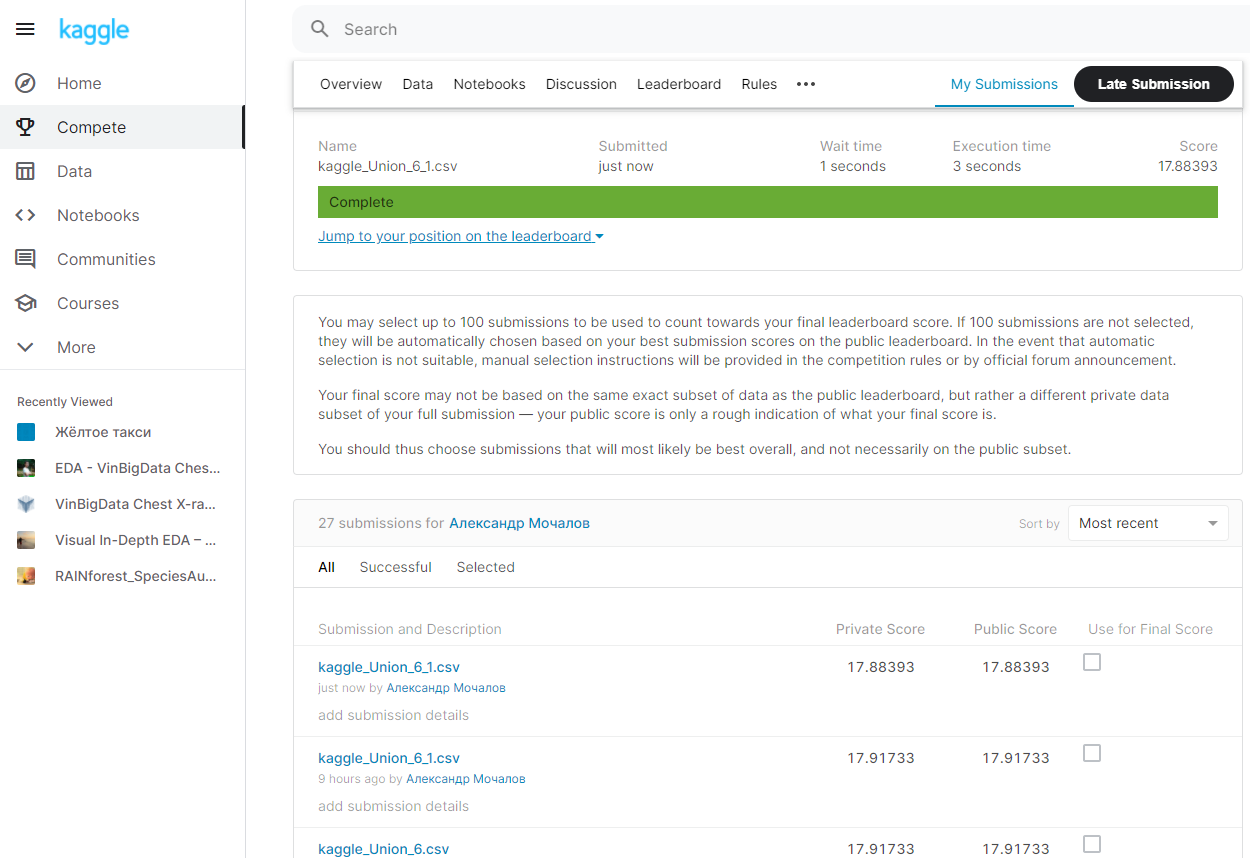

In [98]:
from IPython.display import Image
Image("sub2.png")

### ОБЩИЙ ВЫВОД: как видим результаты улучшились по сравнению с 5ой неделей!!!

#### Улучшение незначительное, ожидал большего. Сначала при добавлении признаков, наоборот уменьшилось качество. (Я на добавленные количественные признаки  так же делал PolynomialFeatures). Пришлось убирать перемножение признаков и просто их добавлять. Так же ожидал, что от ввода категориальных признаков для праздников и выделения именно субботы и воскресенья,- качество БОЛЕЕ улучшится. К сожалению нет(. $\color{red}{\text{Видение как работать дальше есть, но модели ОЧЕНЬ долго обучаются, так что остановился на этом результате.}}$